In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred
fred = Fred(api_key='388e4633f23c88b89679b89794f572ed')

# Initial analysis


In [92]:
consumerloans_series = fred.get_series('CCLACBW027SBOG')
consumerloans_df = pd.DataFrame(consumerloans_series, columns=['consumerloans'])
consumerloans_df
# first date is 2000-06-28, last is 2024-04-10

,consumerloans
2000-06-28,211.4984
2000-07-05,212.0107
2000-07-12,210.8742
2000-07-19,212.5366
2000-07-26,211.7712
...,...
2024-03-13,1053.4000
2024-03-20,1054.5657
2024-03-27,1053.8033
2024-04-03,1054.3702


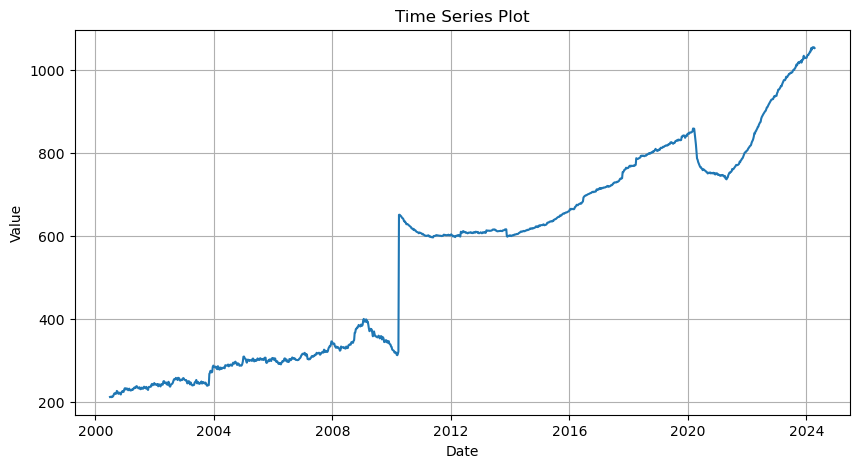

In [93]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(consumerloans_df)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Adjusting for jumps


Jumps noted by fedreserve in billions

January 5, 2022 - 1.7
October 14, 2020 - 1.5
October 16, 2019 - 8.1
April 4, 2018 - 14.1
October 18, 2017 - 13.8
November 20, 2013 - -16.2
March 13, 2013 - 5.2
May 2, 2012 - 9.0
March 31, 2010 - 334.9
October 1, 2008 - 15.6
July 4, 2007 - 2.6
June 21, 2006 - -7.2
October 5, 2005 - -2.4
February 9, 2005 - -1.7
December 29, 2004 - 12.0
April 21, 2004 - -1.8
December 17, 2003 - 7.4
November 5, 2003 - 22.4
July 2, 2003 - 0.7


In [94]:
# you could either add jump amounts to prior dates or subtract from following dates to normalize. I will add to prior dates.
# Creating the jump dictionary
jumps = {
    'Date': ['January 5, 2022', 'October 14, 2020', 'October 16, 2019', 'April 4, 2018',
             'October 18, 2017', 'November 20, 2013', 'March 13, 2013', 'May 2, 2012',
             'March 31, 2010', 'October 1, 2008', 'July 4, 2007', 'June 21, 2006',
             'October 5, 2005', 'February 9, 2005', 'December 29, 2004', 'April 21, 2004',
             'December 17, 2003', 'November 5, 2003', 'July 2, 2003'],
    'Value': [1.7, 1.5, 8.1, 14.1, 13.8, -16.2, 5.2, 9.0, 334.9, 15.6, 2.6, -7.2, -2.4, -1.7, 12.0, -1.8, 7.4, 22.4, 0.7]
}

# Convert date strings to datetime objects
jump_df = pd.DataFrame(jumps)
jump_df['Date'] = pd.to_datetime(jump_df['Date'])
jump_df = jump_df.set_index('Date')

In [95]:
consumerloans_clean = consumerloans_df.merge(jump_df, how='left', left_index=True, right_index=True)
consumerloans_clean.rename(columns={'Value': 'jump'}, inplace=True)
consumerloans_clean['jump'] = consumerloans_clean['jump'].fillna(0)
consumerloans_clean

,consumerloans,jump
2000-06-28,211.4984,0.0
2000-07-05,212.0107,0.0
2000-07-12,210.8742,0.0
2000-07-19,212.5366,0.0
2000-07-26,211.7712,0.0
...,...,...
2024-03-13,1053.4000,0.0
2024-03-20,1054.5657,0.0
2024-03-27,1053.8033,0.0
2024-04-03,1054.3702,0.0


In [96]:
consumerloans_clean.loc['2022-01-05', 'jump']

1.7

In [97]:
jump_df

,Value
Date,
2022-01-05,1.7
2020-10-14,1.5
2019-10-16,8.1
2018-04-04,14.1
2017-10-18,13.8
2013-11-20,-16.2
2013-03-13,5.2
2012-05-02,9.0
2010-03-31,334.9


In [98]:
# Step 1 & 2: Reverse the DataFrame and compute the cumulative sum of 'jump'
cumulative_jumps = consumerloans_clean['jump'][::-1].cumsum()[::-1]

# Step 4: Add the cumulative jumps to 'consumerloans'
consumerloans_clean['consumerloans'] += cumulative_jumps
consumerloans_clean['consumerloans'] -= consumerloans_clean['jump']
consumerloans_clean

,consumerloans,jump
2000-06-28,631.1984,0.0
2000-07-05,631.7107,0.0
2000-07-12,630.5742,0.0
2000-07-19,632.2366,0.0
2000-07-26,631.4712,0.0
...,...,...
2024-03-13,1053.4000,0.0
2024-03-20,1054.5657,0.0
2024-03-27,1053.8033,0.0
2024-04-03,1054.3702,0.0


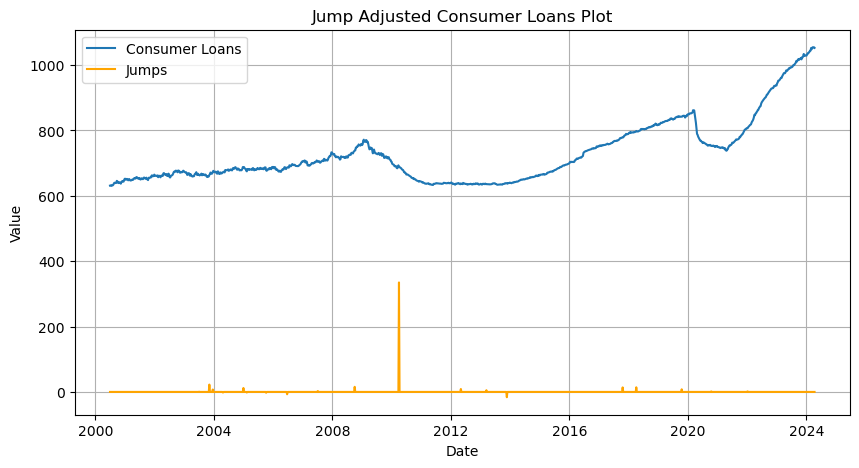

In [99]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(consumerloans_clean['consumerloans'], label='Consumer Loans')
plt.plot(consumerloans_clean['jump'], label='Jumps', color='orange')
plt.title('Jump Adjusted Consumer Loans Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## testing if variance of week-on-week difference changed after march 31, 2010


In [101]:
# Unlike Bartlett's test, which also tests for equal variances but is sensitive to departures from normality, Levene’s test is more robust against non-normal distributions. 
from scipy.stats import levene

# Specify the cut-off date
cut_off_date = pd.Timestamp('2010-03-31')

# Split the data into two segments
before = consumerloans_clean[consumerloans_clean.index < cut_off_date]
after = consumerloans_clean[consumerloans_clean.index >= cut_off_date]

# Calculate week-on-week differences
diff_before = before['consumerloans'].diff().dropna()
diff_after = after['consumerloans'].diff().dropna()

# Calculate variances
var_before = diff_before.var()
var_after = diff_after.var()

# Statistical test for equality of variance
stat, p_value = levene(diff_before, diff_after)

print(f"Variance Before: {var_before}")
print(f"Variance After: {var_after}")
print(f"Levene's test statistic: {stat}, p-value: {p_value}")


Variance Before: 9.199527814788091
Variance After: 4.931355350459442
Levene's test statistic: 68.96619317742942, p-value: 2.5982168044433147e-16


For some reason, there is significant difference before and after March 31, 2010. Assume this is because more things are accounted for in reporting after.
Will use variance after this date when finding variance of week-on-week difference.